# <img style="float: left; padding-right: 10px; width: 45px" src="http://www.ufopa.edu.br/media/file/site/ufopa/imagens/2018/f277f8862c1cc28b26ed9525312ccbfa.jpg"> LAB02 - Preparação e Exploração dos Dados


## Disciplina: Inteligência Artificial

**Bacharelado em Sistemas de Informação**<br>
**Turmas 2018 e 2019**<br>
**Professora:** Dra. Flávia Monteiro <br>

---

In [3]:
#Execute esta celula
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [4]:
# import as bibliotecas necessárias
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'

### Nos iremos usar o dataset 'Titanic' 

O arquivo `titanic.csv` contém dados de 887 passageiros do Titanic. Cada linha representa uma pessoa. As colunas descrevem diferentes atributos sobre a pessoa, incluindo se ela sobreviveu, sua idade, sua classe a bordo, seu sexo e a tarifa que pagou. 

In [32]:
titanic = sns.load_dataset('titanic');
titanic.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


In [33]:
titanic.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'], dtype='object')

In [34]:
columns = ['embarked', 'who', 'adult_male', 'embark_town', 'alive', 'alone']
titanic = titanic.drop(columns=columns)
titanic

,survived,pclass,sex,age,sibsp,parch,fare,class,deck
0,0,3,male,22.0,1,0,7.2500,Third,NaN
1,1,1,female,38.0,1,0,71.2833,First,C
2,1,3,female,26.0,0,0,7.9250,Third,NaN
3,1,1,female,35.0,1,0,53.1000,First,C
4,0,3,male,35.0,0,0,8.0500,Third,NaN
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,Second,NaN
887,1,1,female,19.0,0,0,30.0000,First,B
888,0,3,female,NaN,1,2,23.4500,Third,NaN
889,1,1,male,26.0,0,0,30.0000,First,C


In [16]:
missing_decks = len(titanic[(pd.isna(titanic['deck']) == True)])
missing_decks

688

### Histogramas

#### Traçando a distribuição de uma variável (categórica e contínua)

A maneira mais conveniente de dar uma olhada rápida em uma distribuição univariada em `seaborn` é a função` distplot () `. Por padrão, isso irá desenhar um histograma e ajustar uma estimativa de densidade do kernel (KDE).

Um histograma exibe uma distribuição quantitativa (numérica) mostrando o número (ou porcentagem) dos valores de dados que caem em intervalos especificados. Os intervalos estão no eixo x e o número de valores caindo em cada intervalo, mostrado como um número ou porcentagem, é representado por barras desenhadas acima dos intervalos correspondentes.

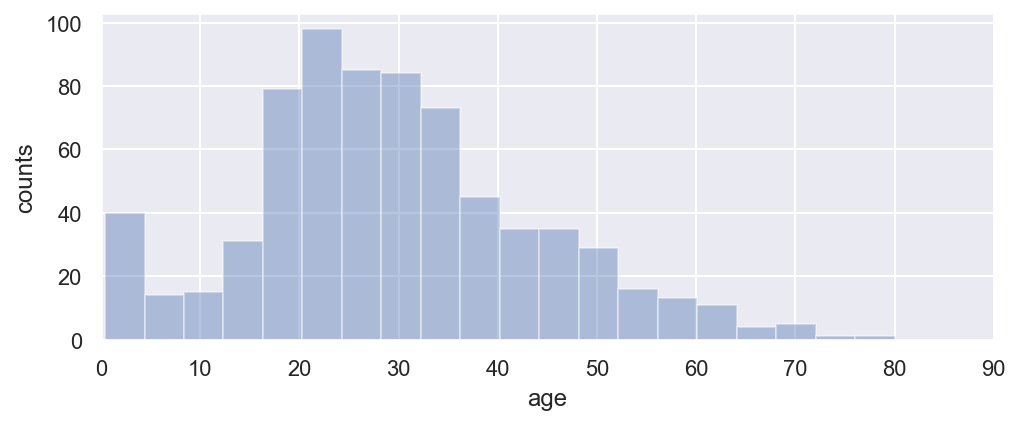

In [17]:
# Qual foi a distribuição de idade entre os passageiros no Titanic? 
import seaborn as sns
sns.set(color_codes=True)

f, ax = plt.subplots(1,1, figsize=(8, 3));
ax = sns.distplot(titanic.age, kde=False, bins=20)

# bug
#ax = sns.distplot(titanic.age, kde=False, bins=20).set(xlim=(0, 90));

ax.set(xlim=(0, 90));
ax.set_ylabel('counts');

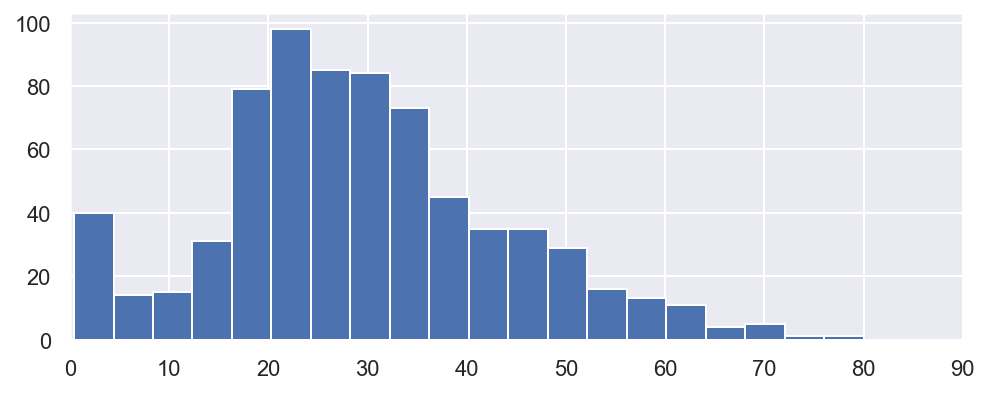

In [12]:
f, ax = plt.subplots(1,1, figsize=(8, 3))
ax.hist(titanic.age, bins=20);
ax.set_xlim(0,90);

In [13]:
infants = len(titanic[(titanic.age < 3)]) 
children = len(titanic[(titanic.age >= 3) & (titanic.age < 10)]) 
print(f'There were {infants} infants and {children} children on board the Titanic')

There were 24 infants and 38 children on board the Titanic


**Pandas trick:** Queremos criar "caixas" virtuais para facilitar a leitura e substituir intervalos de valores por categorias.

Faremos isso de forma ad hoc, ** pode ser feito melhor **. Por exemplo, no gráfico anterior, poderíamos definir:
    
- `(age<3) = 'infants'`, 
- `(3<age<18)='children'`, 
- `(18<values<90)='adults'` <BR>

Veja mais em matplotlib [colors](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) aqui.

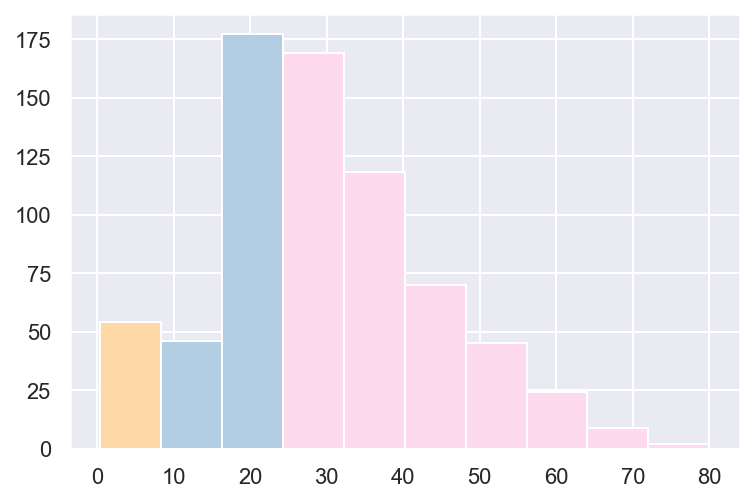

In [18]:
# configure as cores
cmap = plt.get_cmap('Pastel1')
young = cmap(0.5)
middle = cmap(0.2)
older = cmap(0.8)

# obter o objeto que iremos alterar - patches é uma matriz com len: número de caixas
fig, ax = plt.subplots()
y_values, bins, patches = ax.hist(titanic.age, 10)

[patches[i].set_facecolor(young) for i in range(0,1)] # bin 0
[patches[i].set_facecolor(middle) for i in range(1,3)] # bins 1 and 2
[patches[i].set_facecolor(older) for i in range(3,10)] # 7 remaining bins 

ax.grid(True)
fig.show()

#### Estimativa de densidade do kernel
A estimativa da densidade do kernel pode ser uma ferramenta útil para traçar a forma de uma distribuição. O parâmetro ** largura de banda (bw) ** do KDE controla a precisão com que a estimativa se ajusta aos dados, como o tamanho do compartimento em um histograma. Corresponde à largura dos grãos que plotamos acima. O comportamento padrão tenta adivinhar um bom valor usando uma regra de referência comum, mas pode ser útil tentar valores maiores ou menores.

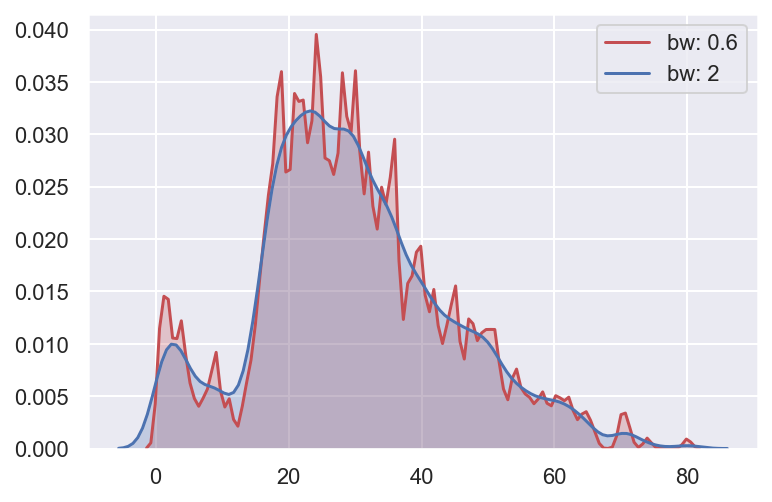

In [78]:
sns.kdeplot(titanic.age, bw=0.6, label="bw: 0.6", shade=True, color="r");
sns.kdeplot(titanic.age, bw=2, label="bw: 2", shade=True);

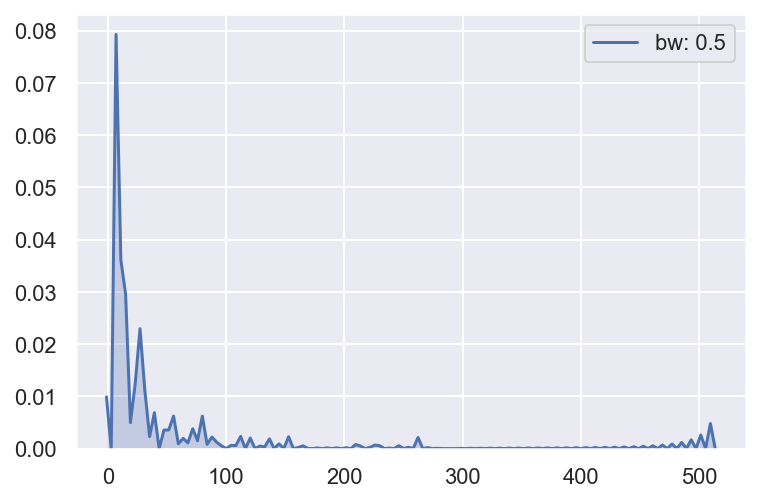

In [19]:
sns.kdeplot(titanic.fare, bw=0.5, label="bw: 0.5", shade=True);

#### Você pode misturar elementos de `matplotlib` como Axes com elementos` seaborn` para um melhor uso de ambos os mundos.

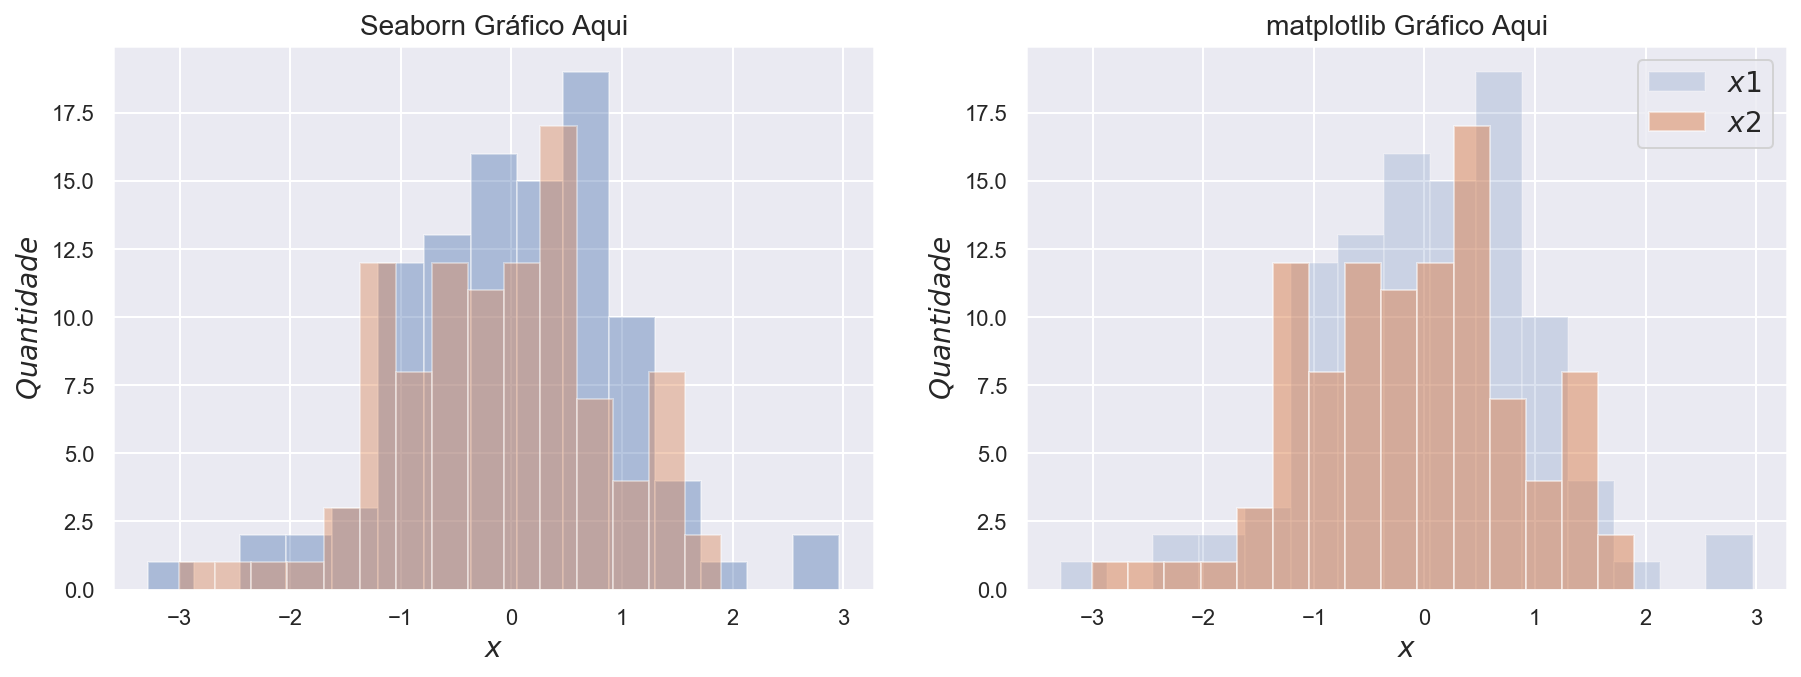

In [22]:
import seaborn as sns
sns.set(color_codes=True)

x1 = np.random.normal(size=100)
x2 = np.random.normal(size=100)

fig, ax = plt.subplots(1,2, figsize=(15,5))

# seaborn goes in first subplot
sns.set(font_scale=0.5)
sns.distplot(x1, kde=False, bins=15, ax=ax[0]);
sns.distplot(x2, kde=False, bins=15, ax=ax[0]);
ax[0].set_title('Seaborn Gráfico Aqui', fontsize=14)
ax[0].set_xlabel(r'$x$', fontsize=14)
ax[0].set_ylabel(r'$Quantidade$', fontsize=14)

# matplotlib goes in second subplot
ax[1].hist(x1, alpha=0.2, bins=15, label=r'$x1$');
ax[1].hist(x2, alpha=0.5, bins=15, label=r'$x2$');
ax[1].set_xlabel(r'$x$', fontsize=14)
ax[1].set_ylabel(r'$Quantidade$', fontsize=14)
ax[1].set_title('matplotlib Gráfico Aqui', fontsize=14)
ax[1].legend(loc='best', fontsize=14);

#### Apresentando o conjunto de dados de doenças cardíacas.

Mais sobre isso no exercício em sala de aula no final do bloco de notas.

In [37]:
columns = ["age", "sex", "cp", "restbp", "chol", "fbs", "restecg", 
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
heart_df = pd.read_csv('data/heart_disease.csv', header=None, names=columns)

heart_df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd,NaN,NaN,NaN
1,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1,NaN,NaN,NaN
2,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1,NaN,NaN,NaN
3,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0,NaN,NaN,NaN
4,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1,NaN,NaN,NaN


### Boxplots

#### Uma variável.

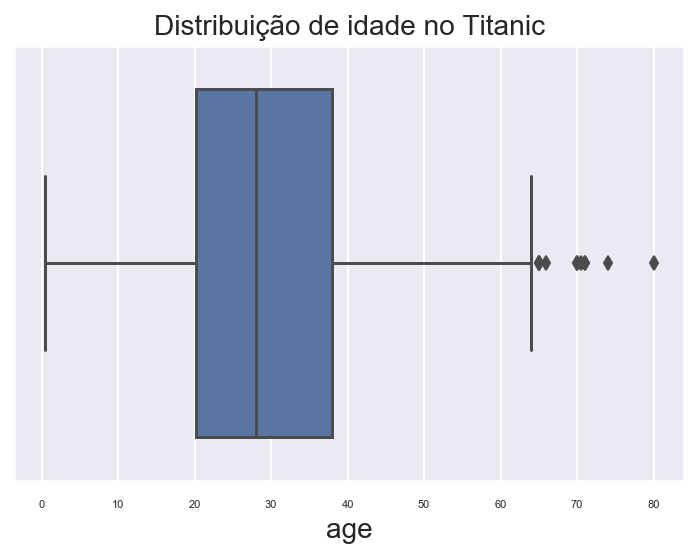

In [38]:
# seaborn
ax = sns.boxplot(x='age', data=titanic)
#ax = sns.boxplot(x=titanic['age']) # outra forma de codificar
ax.set_ylabel(None);
ax.set_xlabel('age', fontsize=14);
ax.set_title('Distribuição de idade no Titanic', fontsize=14);

#### Duas variáveis

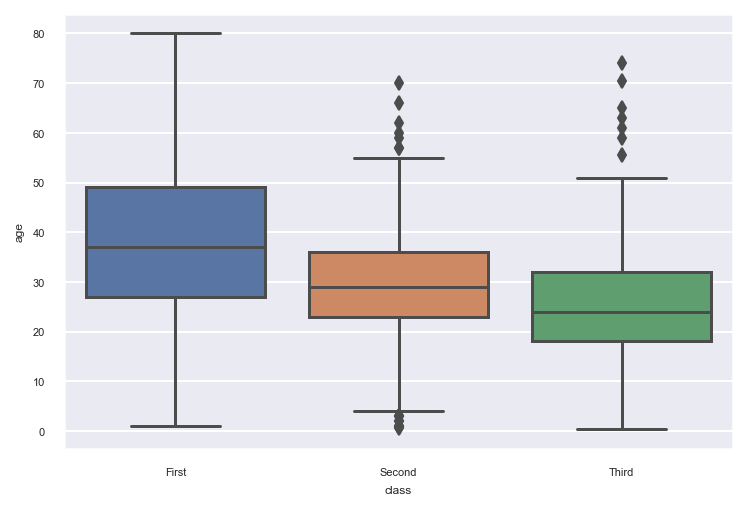

In [39]:
ax = sns.boxplot(x='class', y='age', data=titanic)

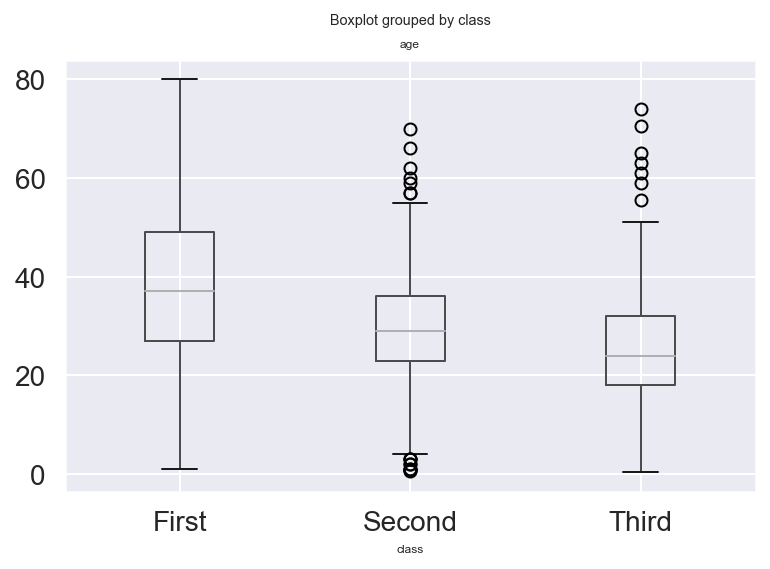

In [40]:
# two variable boxplot in pandas
titanic.boxplot('age',by='class', fontsize=14)

### Scatterplots

#### Traçando a distribuição de duas variáveis

Também chamada de distribuição bivariada, em que cada observação é mostrada com um ponto com os valores xey. Você pode desenhar um gráfico de dispersão com a função `matplotlib plt.scatter` ou a função` seaborn jointplot () `:

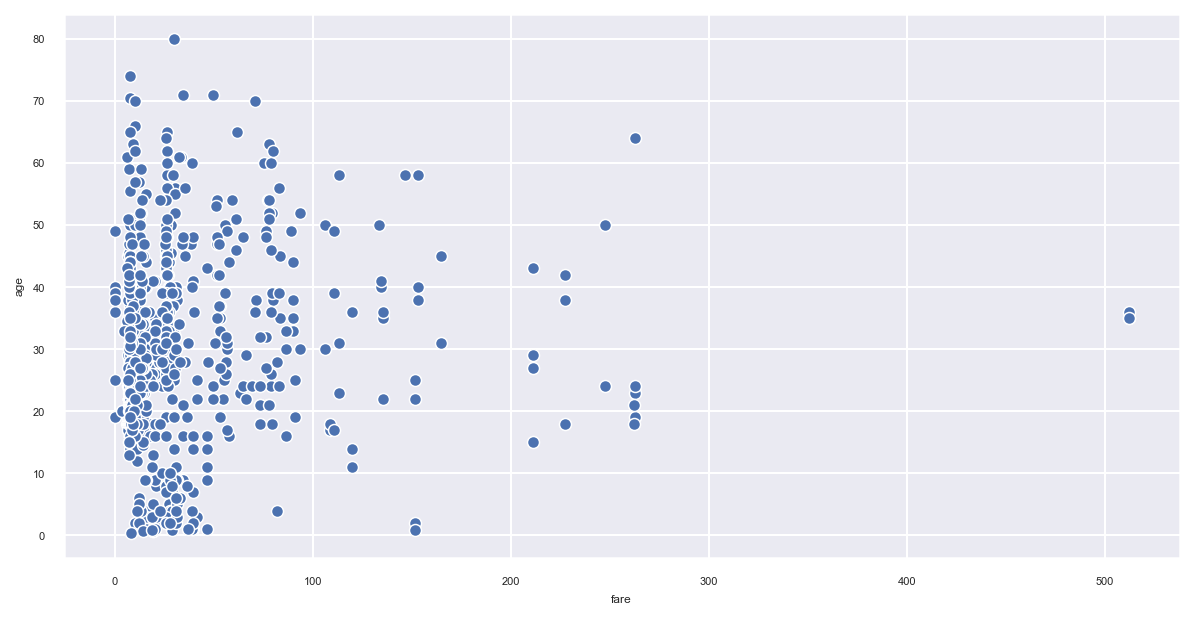

In [41]:
f, ax = plt.subplots(1,1, figsize=(10, 5))
sns.scatterplot(x="fare", y="age", data=titanic, ax=ax); 

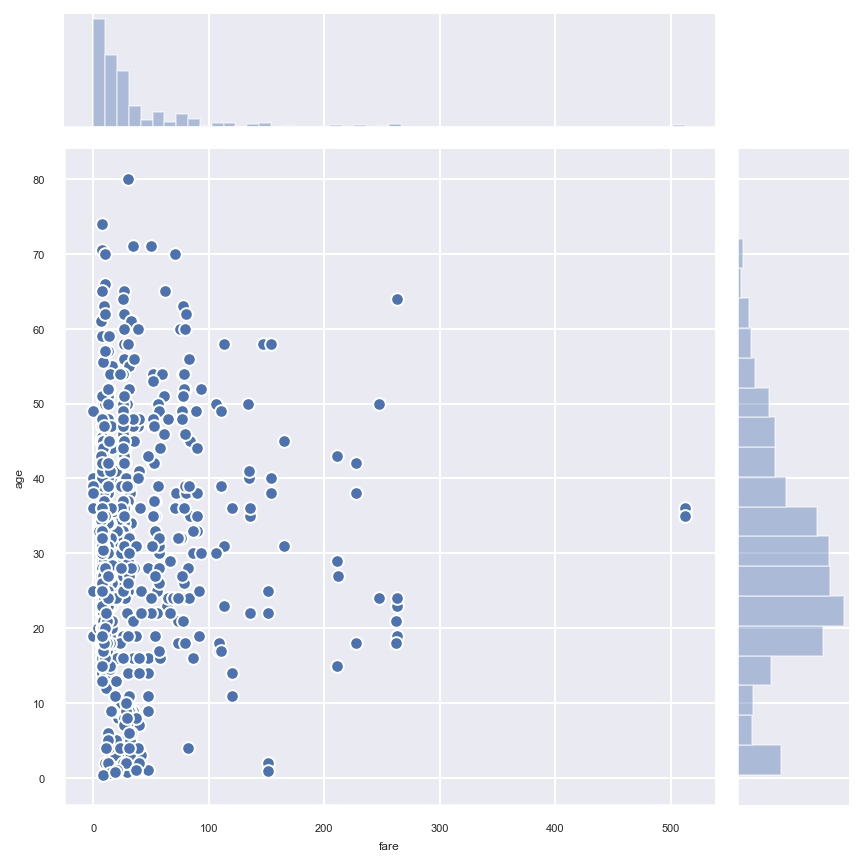

In [42]:
sns.jointplot("fare", "age", data=titanic, s=40, edgecolor="w", linewidth=1)

Você pode controlar o `seaborn` [Figure aesthetics](https://seaborn.pydata.org/tutorial/aesthetics.html).

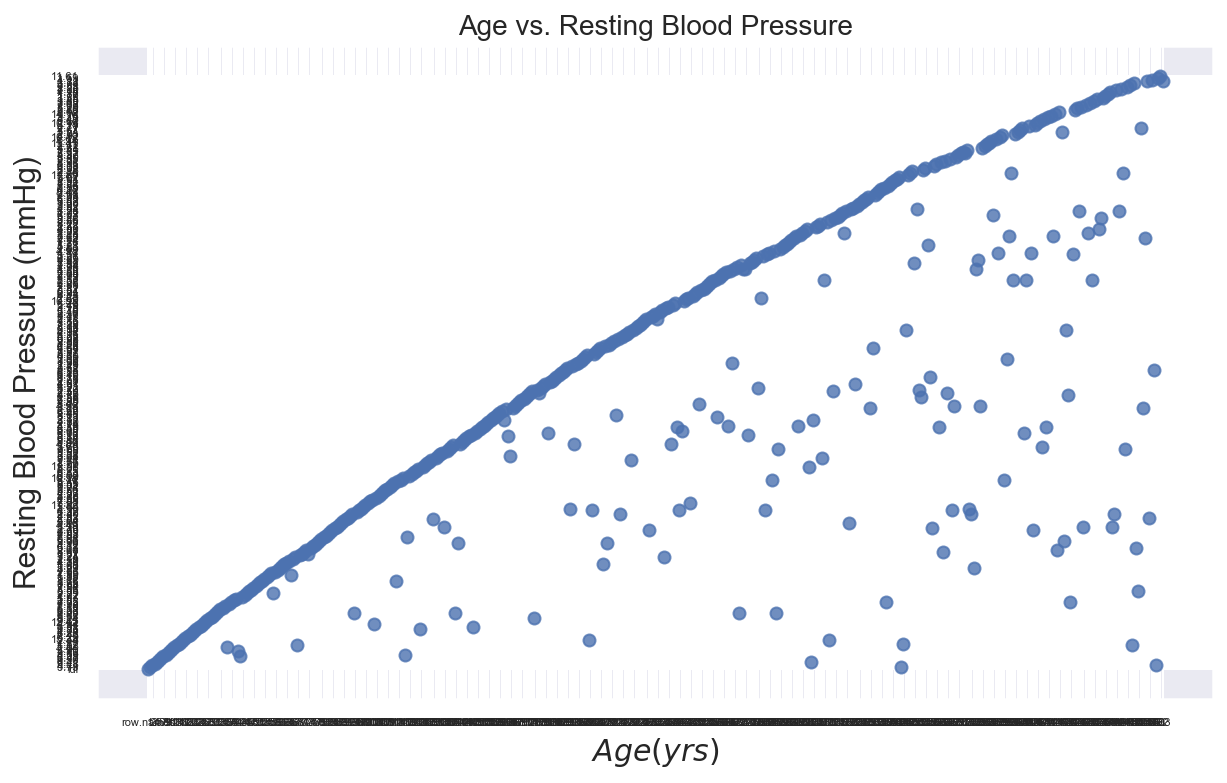

In [43]:
# matplotlib
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(heart_df['age'], heart_df['restbp'], alpha=0.8);
ax.set_xlabel(r'$Age (yrs)$', fontsize=15);
ax.set_ylabel(r'Resting Blood Pressure (mmHg)', fontsize=15);
ax.set_title('Age vs. Resting Blood Pressure', fontsize=14)
plt.show();

#### Plotting the distribution of three variables

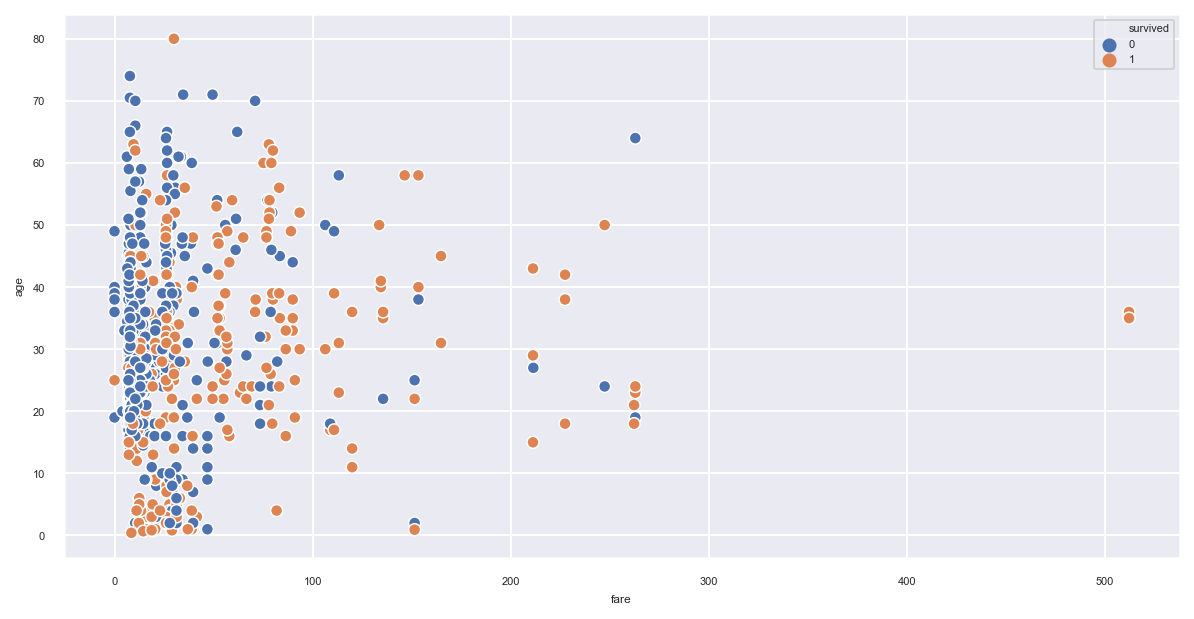

In [22]:
f, ax = plt.subplots(1,1, figsize=(10, 5))
sns.scatterplot(x="fare", y="age", hue="survived", data=titanic, ax=ax);

#### Traçando a distribuição de quatro variáveis (indo longe demais?)

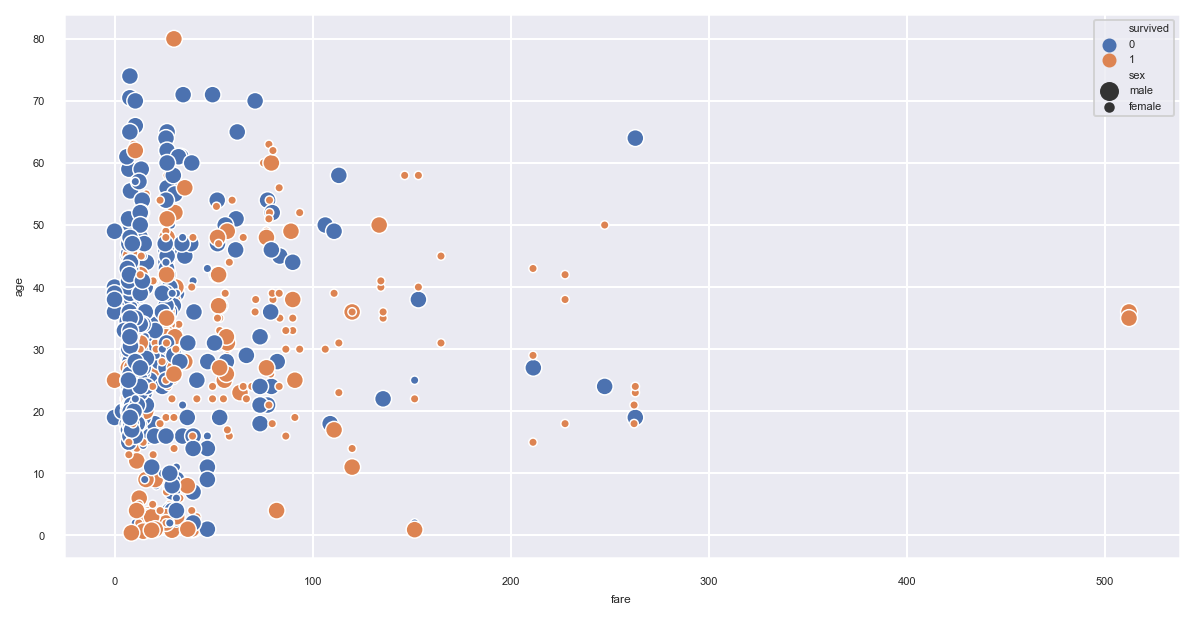

In [44]:
# your code here
f, ax = plt.subplots(1,1, figsize=(10, 5))
sns.scatterplot(x="fare", y="age", hue="survived", size="sex", data=titanic, ax=ax);

### Pairplots

In [24]:
titanic.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'deck'], dtype='object')

In [25]:
to_plot = ['age', 'fare', 'survived', 'deck']

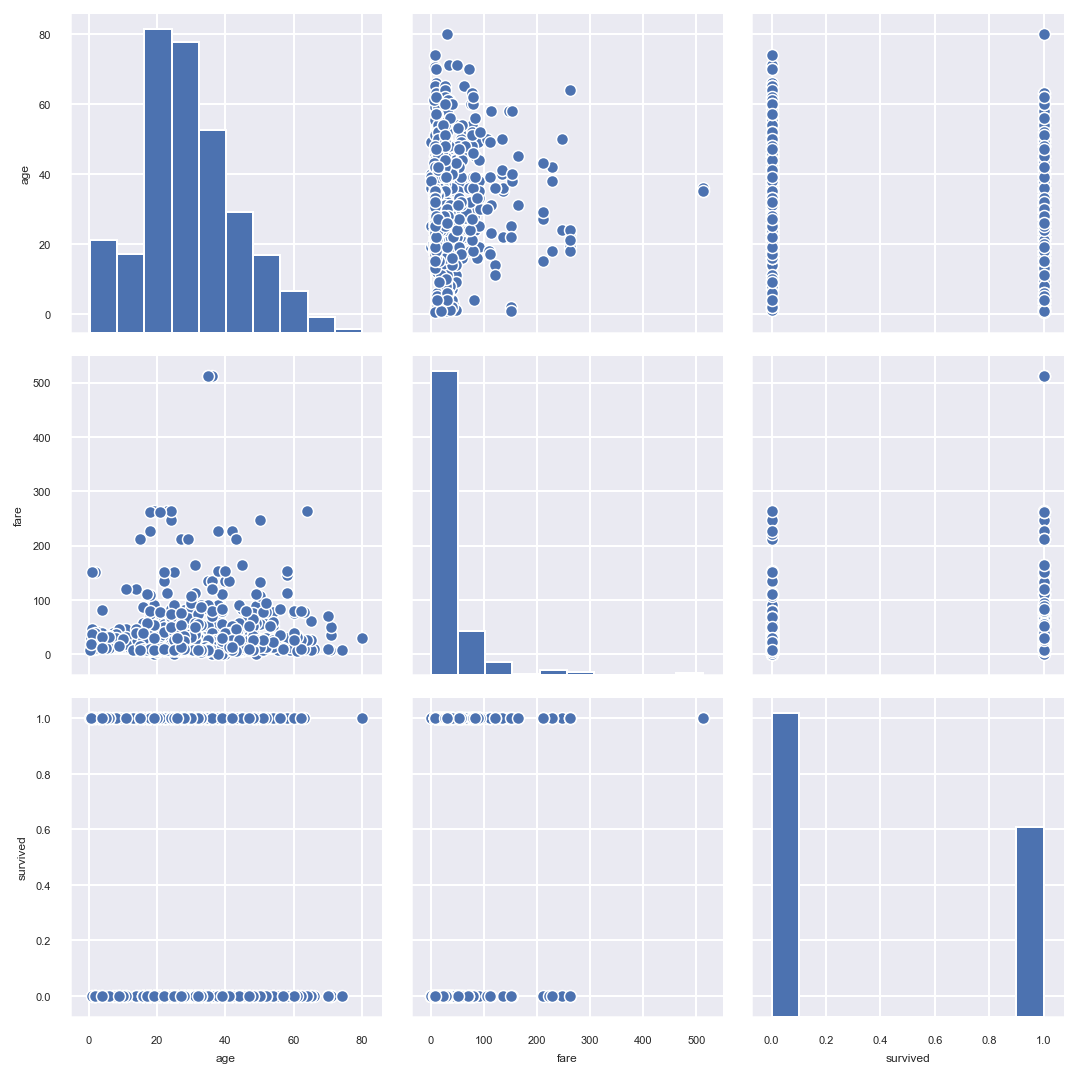

In [28]:
df_to_plot = titanic.loc[:,to_plot]
sns.pairplot(df_to_plot);

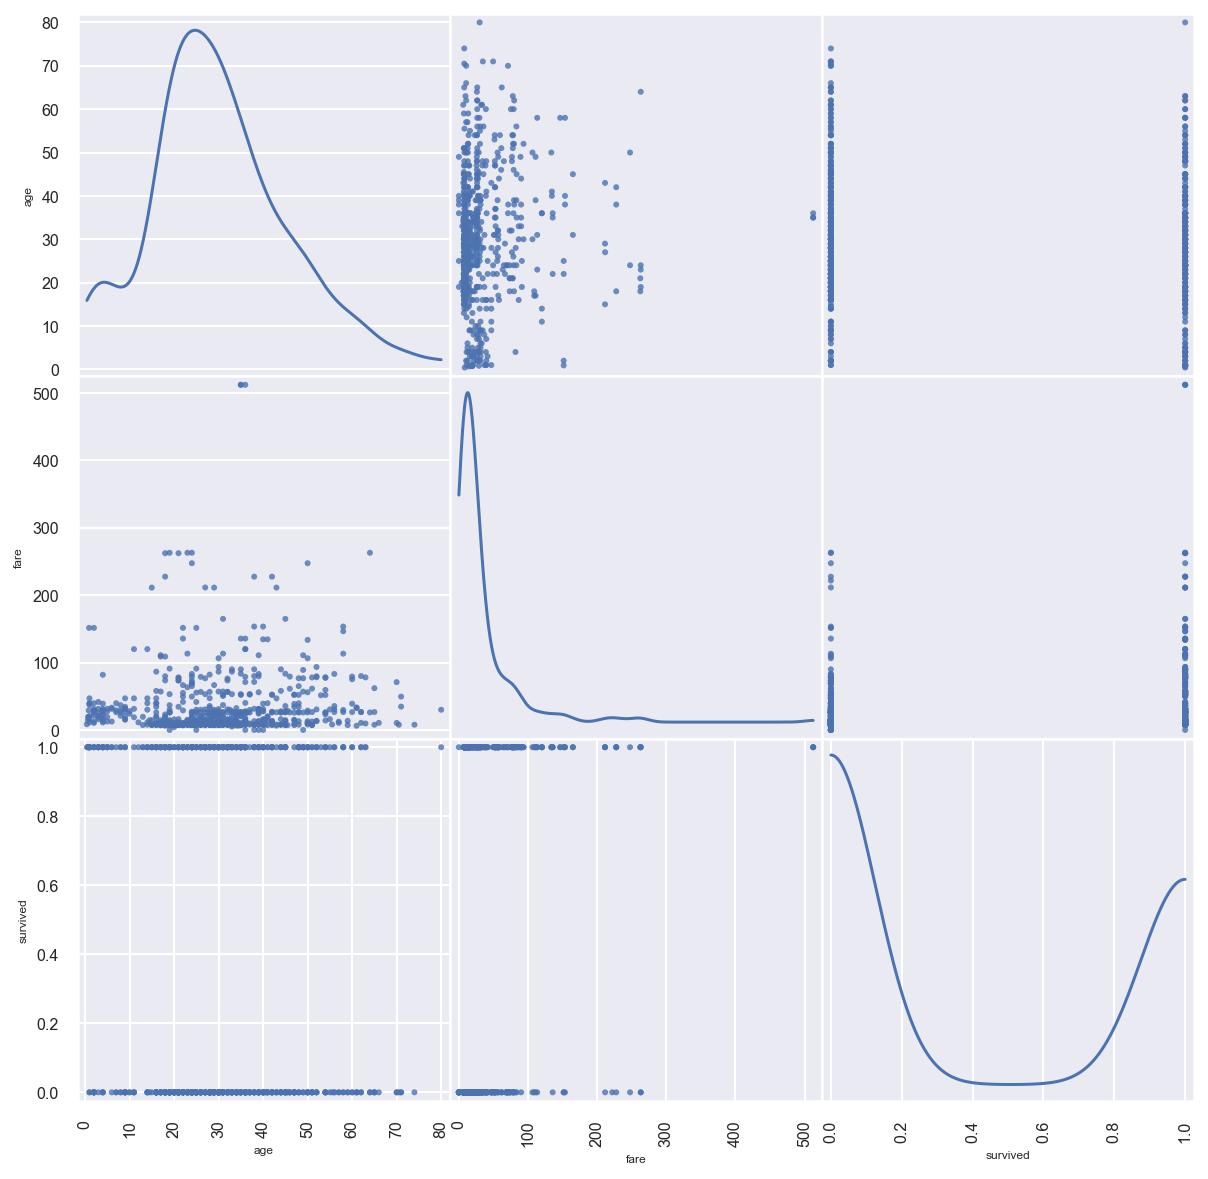

In [29]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_to_plot, alpha=0.8, figsize=(10, 10), diagonal='kde');

### Plotando Variáveis Categóricas

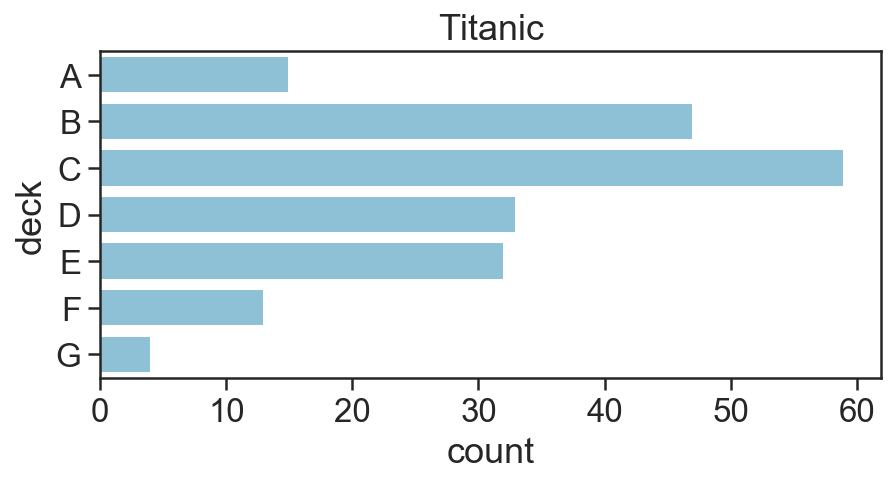

In [35]:
titanic = sns.load_dataset('titanic')
f, ax = plt.subplots(figsize=(7, 3));
ax = sns.countplot(y="deck", data=titanic, color="c");
ax.set_title('Titanic');

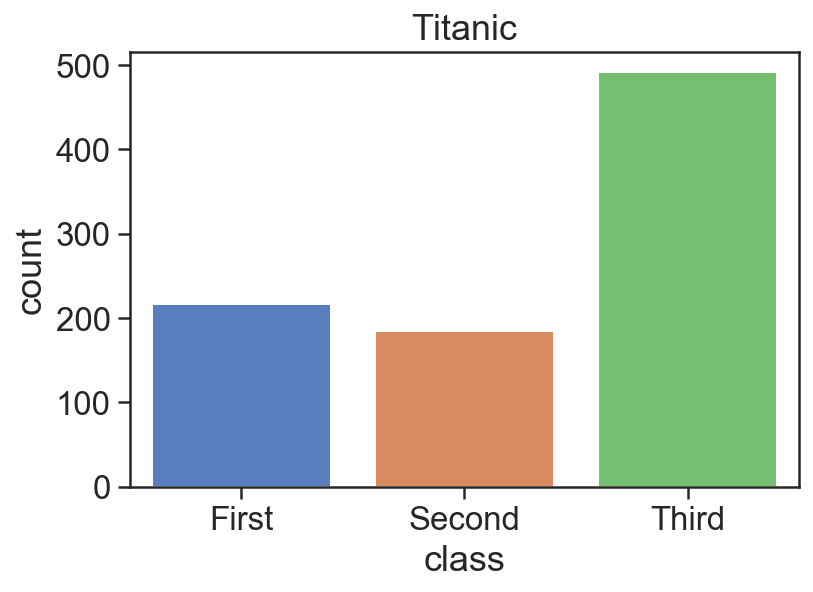

In [42]:
ax = sns.countplot(x="class", data=titanic)
ax.set_title('Titanic');

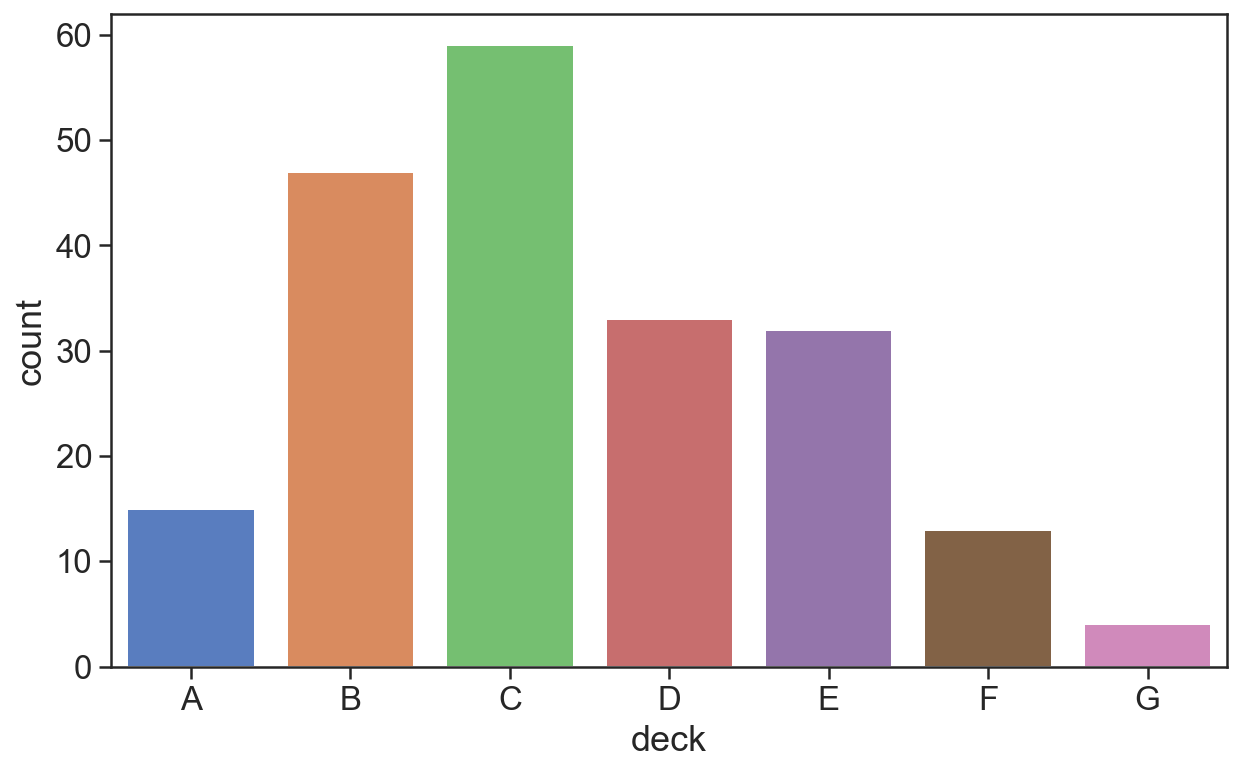

In [43]:
fig, ax = plt.subplots(figsize=(10,6)) # Create figure object
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
ax = sns.countplot(x="deck", data=titanic)

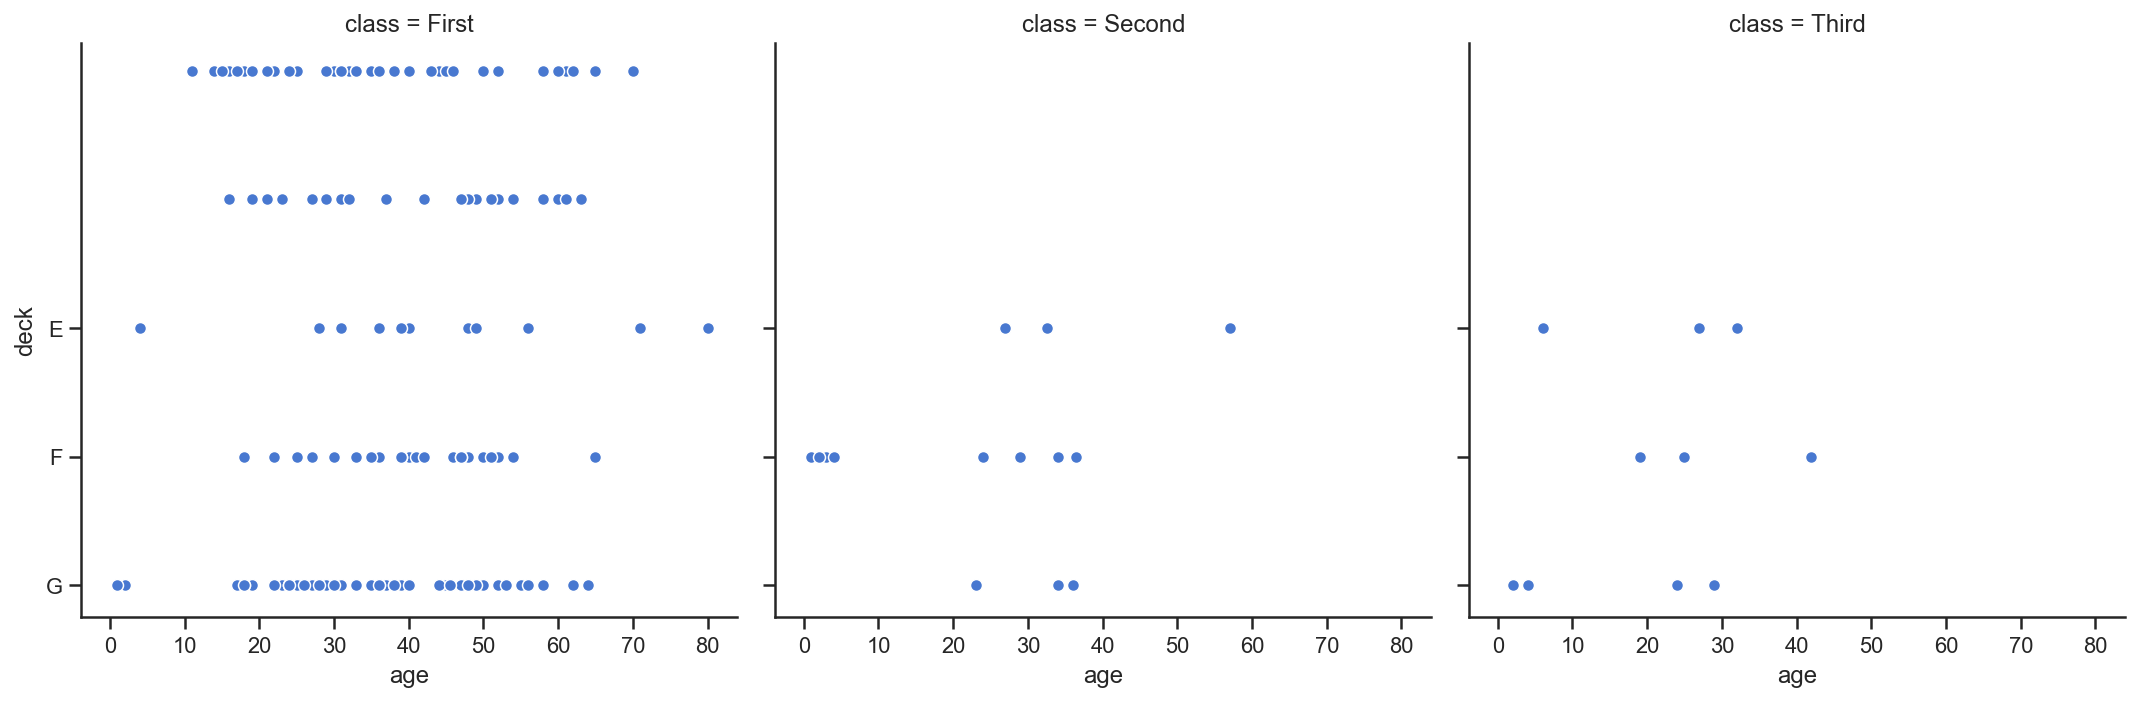

In [44]:
sns.set(style="ticks", palette="muted")
sns.relplot(x="age", y="deck", col="class", data=titanic);

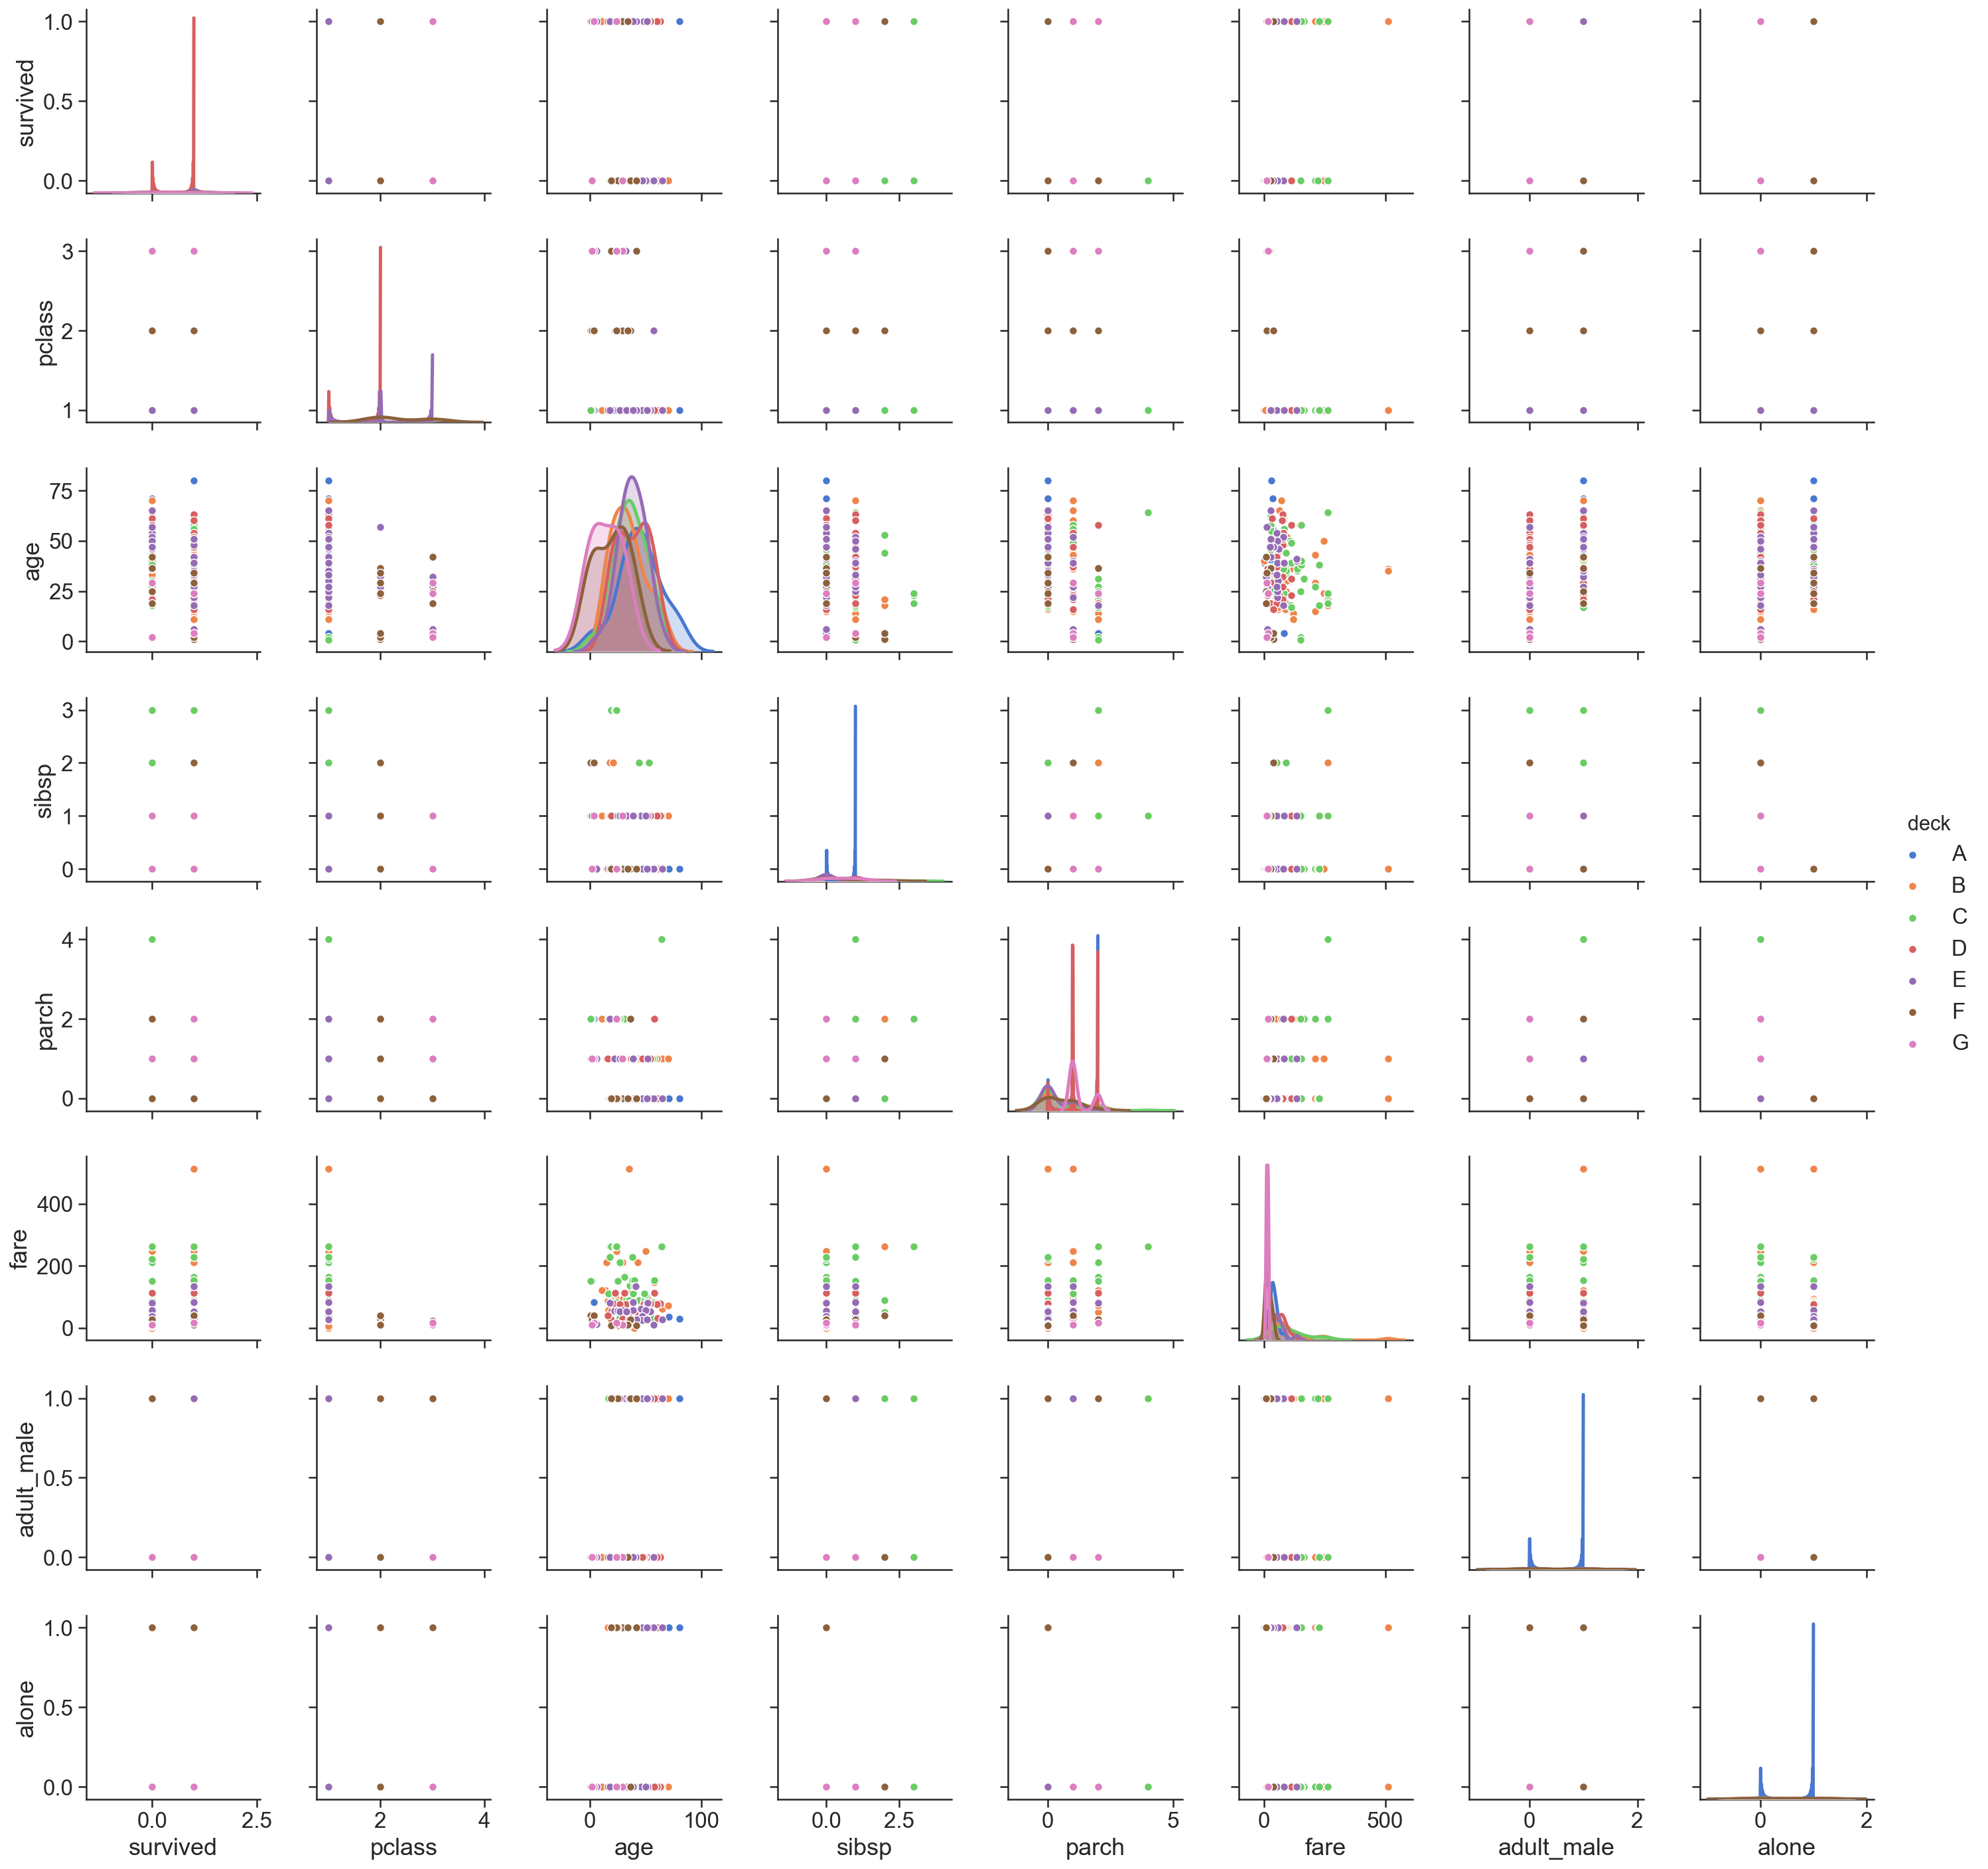

In [45]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.pairplot(data=titanic, hue="deck");

### Introdução ao plot com `pandas`.

### Line Graph

#### Bom para dependência de tempo ou quando uma variável evolui

In [46]:
df = pd.DataFrame(np.random.randn(1000, 4), columns=['A', 'B', 'C', 'D'])
df.head()

,A,B,C,D
0,0.201468,0.002378,0.460038,-0.620872
1,-1.347740,2.317959,-0.128938,1.129856
2,0.827727,-1.546181,-1.576246,-1.113427
3,0.345499,1.469756,-0.234321,1.381242
4,-0.301247,-0.680943,0.669998,-0.203680


In [47]:
# cumulative sum adds column values as it goes
df = df.cumsum()
df.head()

,A,B,C,D
0,0.201468,0.002378,0.460038,-0.620872
1,-1.146272,2.320337,0.331100,0.508984
2,-0.318545,0.774156,-1.245146,-0.604443
3,0.026954,2.243912,-1.479467,0.776799
4,-0.274293,1.562969,-0.809469,0.573119


<Figure size 432x288 with 0 Axes>

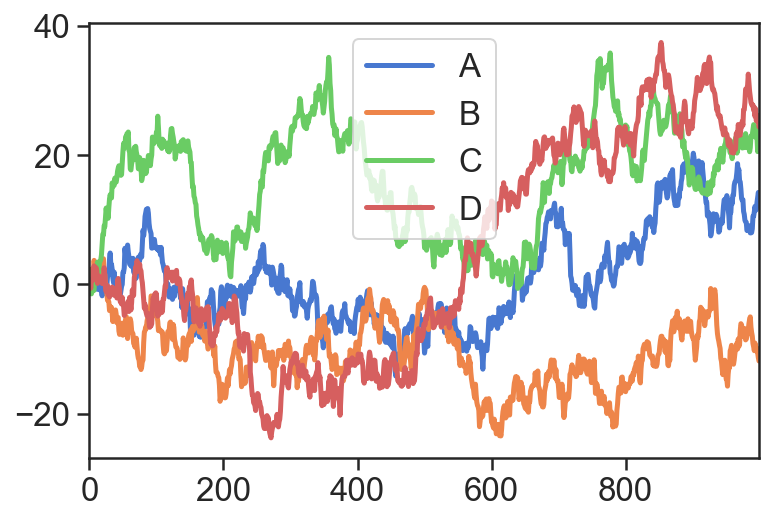

In [48]:
plt.figure();
df.plot();
plt.legend(loc='best');

<Figure size 432x288 with 0 Axes>

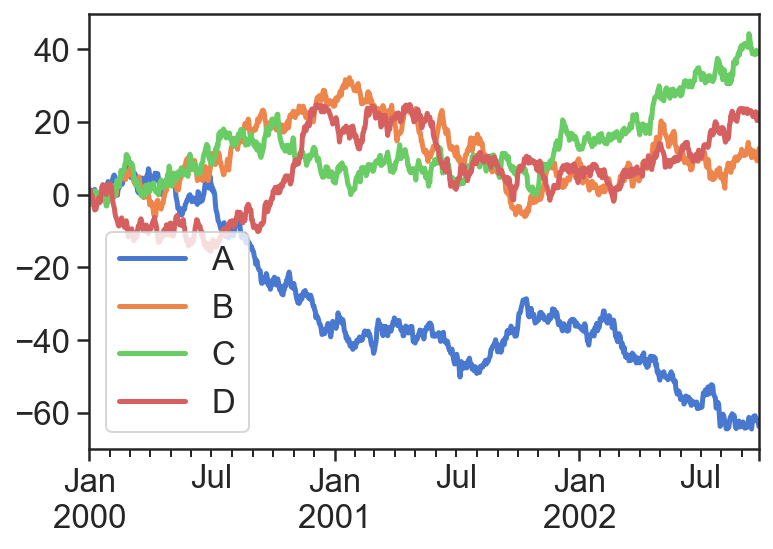

In [49]:
ts = pd.Series(np.random.randn(1000),
               index=pd.date_range('1/1/2000', periods=1000))
df = pd.DataFrame(np.random.randn(1000, 4), 
                  index=ts.index, columns=list('ABCD'))

df = df.cumsum()
plt.figure();
df.plot();

Os métodos de plotagem permitem um punhado de estilos de plotagem além da plotagem de linha padrão. Esses métodos podem ser fornecidos como o argumento de palavra-chave kind para plot () e incluem:

- ‘bar’ or ‘barh’ for bar plots
- ‘hist’ for histogram
- ‘box’ for boxplot
- ‘kde’ or ‘density’ for density plots
- ‘area’ for area plots
- ‘scatter’ for scatter plots
- ‘hexbin’ for hexagonal bin plots
- ‘pie’ for pie plots

Além desses tipos, existem os métodos `DataFrame.hist ()` e `DataFrame.boxplot ()`, que usam uma interface separada. `scatter_matrix` em pandas.plotting leva uma série ou DataFrame como argumento.

### Bar Plots

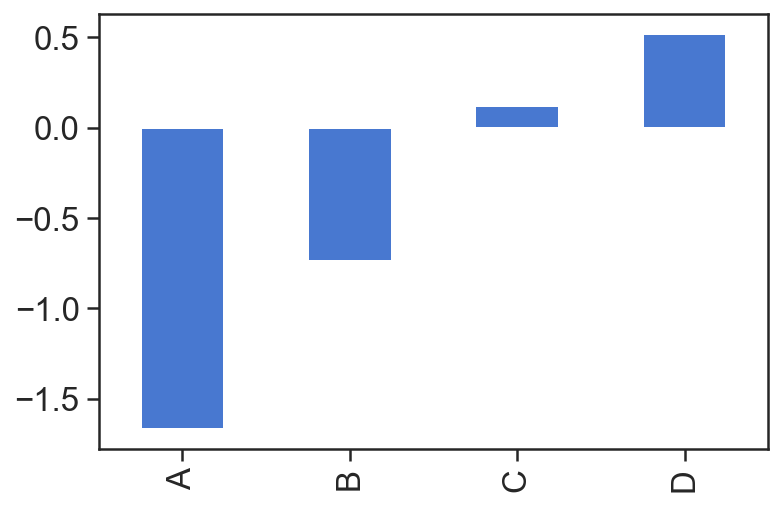

In [50]:
plt.figure();
df.iloc[0].plot(kind='bar');

In [51]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])
df2

,a,b,c,d
0,0.507876,0.850593,0.986939,0.082241
1,0.230224,0.268668,0.462782,0.440504
2,0.597335,0.136271,0.931408,0.238425
3,0.860248,0.465814,0.312943,0.441529
4,0.895884,0.683348,0.955019,0.545084
5,0.990852,0.210919,0.998533,0.153769
6,0.008812,0.337127,0.981830,0.321036
7,0.190601,0.309422,0.617435,0.442801
8,0.700053,0.867143,0.472762,0.792051
9,0.994677,0.087399,0.767110,0.780876


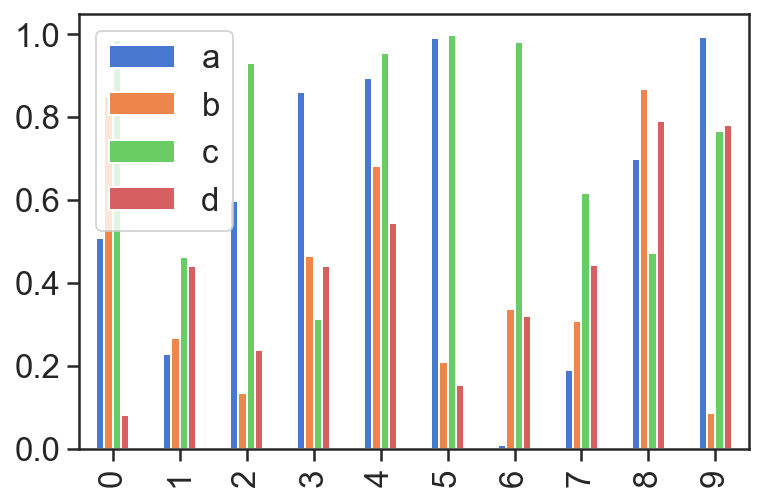

In [52]:
df2.plot.bar();

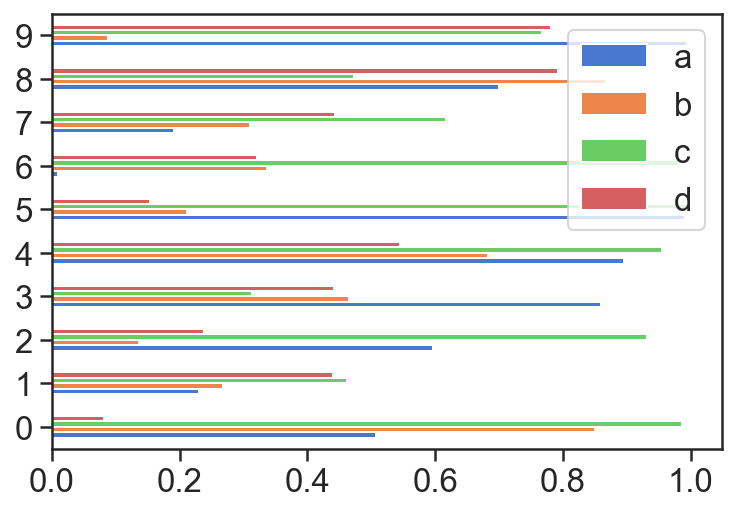

In [53]:
# horizontal bar plot
df2.plot.barh(stacked=False);

### Histograms

<Figure size 432x288 with 0 Axes>

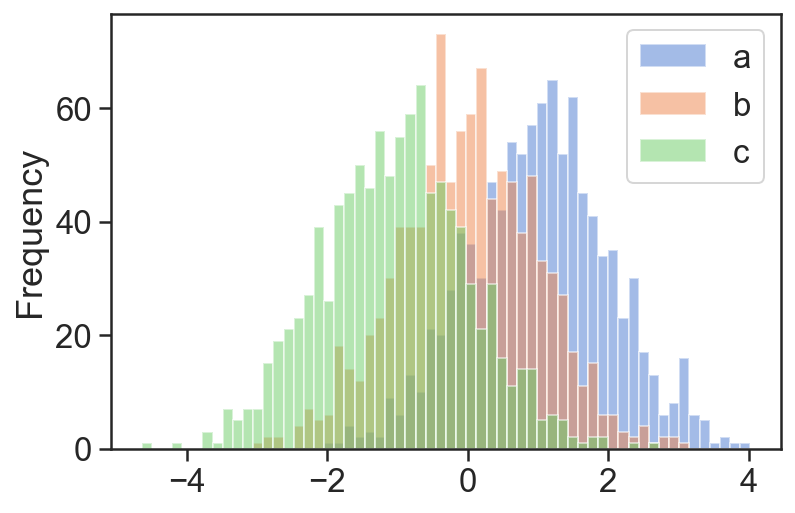

In [54]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000), 
                    'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])

plt.figure();
df4.plot.hist(alpha=0.5, stacked=False, bins=60);

### Boxplots

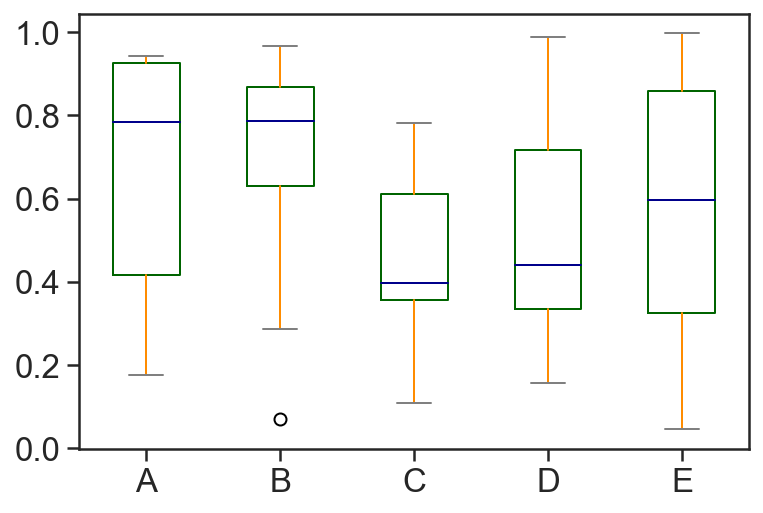

In [55]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange',
         'medians': 'DarkBlue', 'caps': 'Gray'}

df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
df.plot.box(color=color );

### Area plots

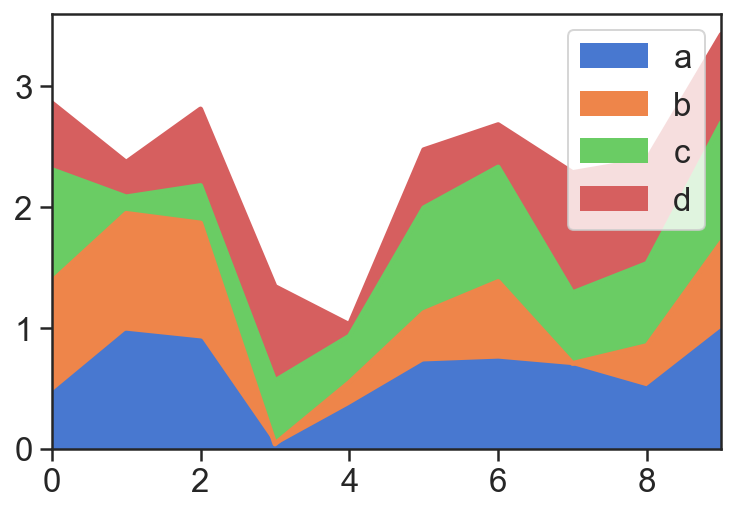

In [56]:
df = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])
df.plot.area(stacked=True);

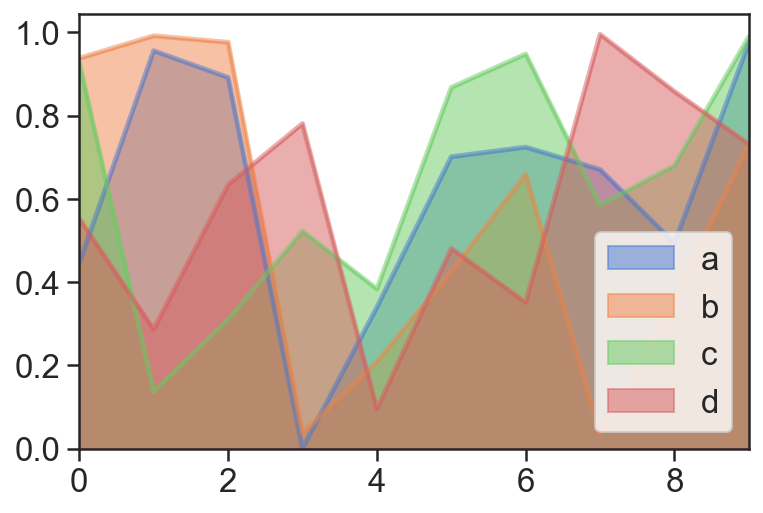

In [57]:
df.plot.area(stacked=False);

### Scatterplot

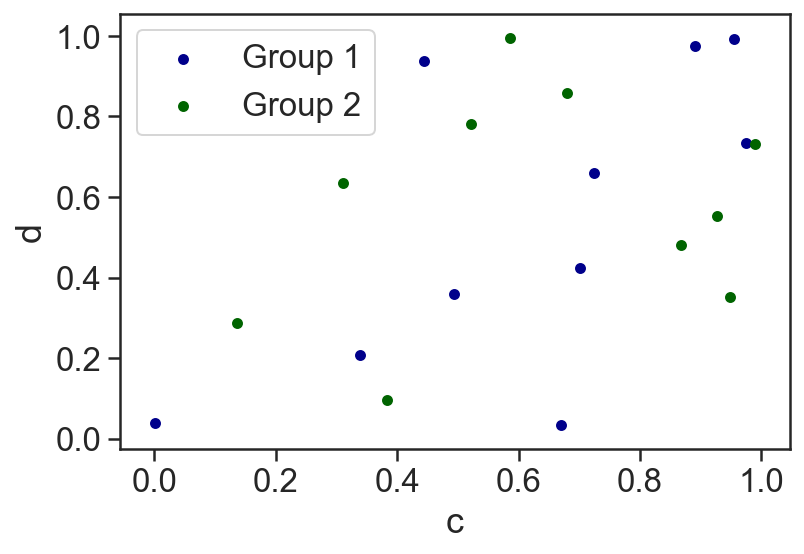

In [58]:
ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Group 1');
df.plot.scatter(x='c', y='d', color='DarkGreen', label='Group 2', ax=ax);